In [1]:
import numpy as np
import scipy as sp
import sklearn as skl
import skimage as ski
import os
from glob import glob
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
dataset = Path("Y:/kau/диплом/data/dataset")
workdir = Path("Y:/kau/диплом/data/run05")

os.makedirs(workdir, exist_ok=True)

In [4]:
descriptors = list(dataset.glob("hist_*.npy"))
descriptors

[WindowsPath('Y:/kau/диплом/data/dataset/hist_R1_P8_d.npy'),
 WindowsPath('Y:/kau/диплом/data/dataset/hist_R1_P8_u.npy'),
 WindowsPath('Y:/kau/диплом/data/dataset/hist_R2_P12_d.npy'),
 WindowsPath('Y:/kau/диплом/data/dataset/hist_R2_P12_u.npy'),
 WindowsPath('Y:/kau/диплом/data/dataset/hist_R3_P24_u.npy'),
 WindowsPath('Y:/kau/диплом/data/dataset/hist_R5_P36_u.npy')]

In [5]:
descriptor = 'hist_R2_P12_d'

In [6]:
chunksize = 100

In [7]:
y = np.load(f"{dataset}/labels.npy")
print(y.shape, y.dtype)
label = y[:,1]
label_subset = y[:,0]

(1950, 2) uint8


# Descriptor hist_R2_P12_d

## 1. Mean

In [8]:
X = np.load(f"{dataset}/{descriptor}.npy")
X.shape, X.dtype

((1950, 4096), dtype('uint32'))

In [9]:
unique_labels, label_sizes = np.unique(label, return_counts=True)
unique_labels, label_sizes

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=uint8),
 array([150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150]))

features stratified by class/label

In [10]:
X_cl = np.array([ X[label == k] for k in unique_labels ])
X_cl.shape, X_cl.dtype

((13, 150, 4096), dtype('uint32'))

In [21]:
np.median(X_cl, axis=(1,2))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

mean histogram for each class

In [22]:
means = X_cl.mean(axis=1)
means.shape, means.dtype

((13, 4096), dtype('float64'))

In [23]:
np.save(workdir / 'X_cl.npy', X_cl)
np.save(workdir / 'means.npy', means)

In [24]:
# let's bin, specially for plotting
X_cl_rebinned = ski.measure.block_reduce(X_cl, (1, 1, 16))
X_cl_rebinned.shape

(13, 150, 256)

In [25]:
means_rebinned = X_cl_rebinned.mean(axis=1)

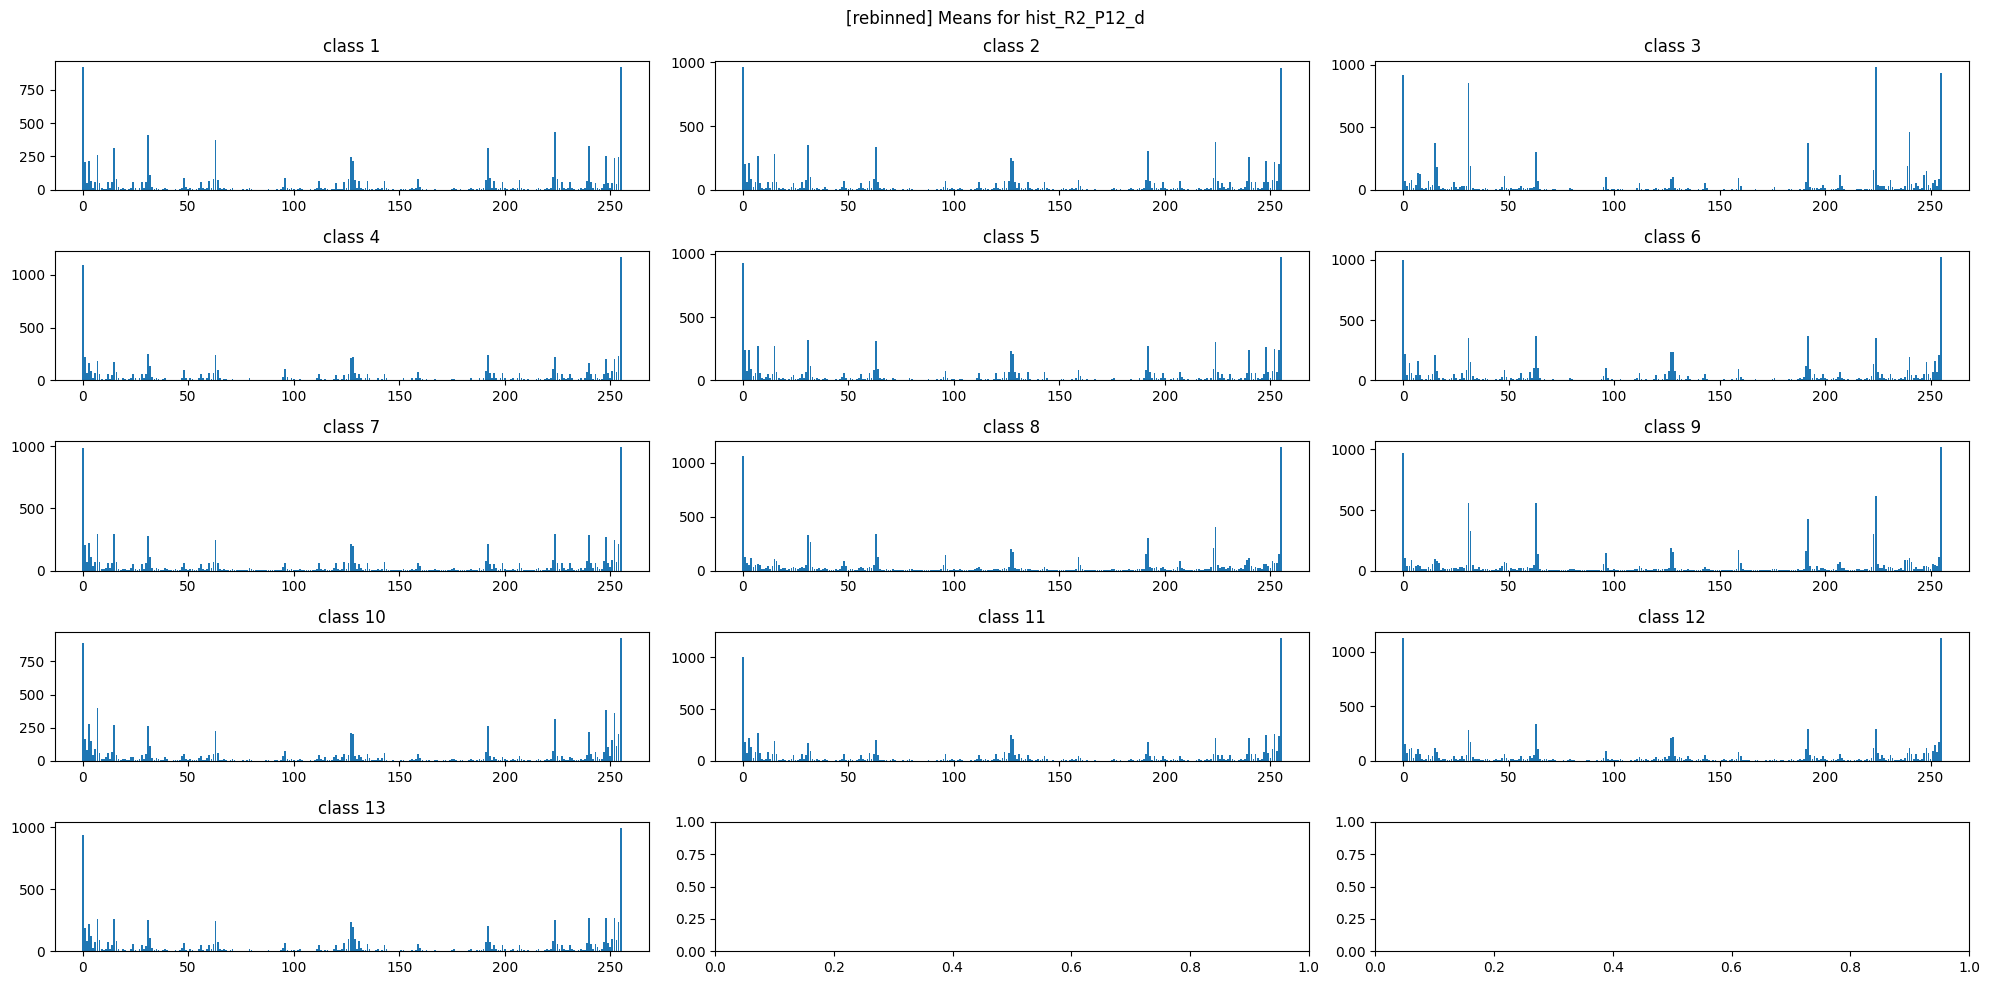

In [26]:
fig, axs = plt.subplots(5, 3)
for k in range(13):
    ax = axs.flat[k]
    ax.bar(range(means_rebinned.shape[1]), means_rebinned[k])
    ax.set_title(f'class {k+1}')
for k in range(13,len(axs)):
    axs.flat[k].set_axis_off()
fig.suptitle(f'[rebinned] Means for {descriptor}')
fig.set_size_inches((20,10))
fig.tight_layout()

### Some descriptive stats for mean histograms

In [27]:
print("Min:", means.min(axis=1))
print("Max:", means.max(axis=1))
print("Sum:", means.sum(axis=1))

Min: [0.         0.         0.         0.         0.         0.
 0.         0.02       0.00666667 0.         0.         0.
 0.        ]
Max: [508.74       536.44666667 538.52       719.82666667 555.56666667
 600.15333333 563.91333333 704.77333333 605.42666667 510.32
 688.25333333 744.35333333 573.91333333]
Sum: [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000.]


In [28]:
print("Min:", means_rebinned.min(axis=1))
print("Max:", means_rebinned.max(axis=1))
print("Sum:", means_rebinned.sum(axis=1))

Min: [0.12       0.32       0.23333333 0.21333333 0.49333333 0.56
 0.78       2.51333333 1.22666667 1.20666667 0.57333333 1.03333333
 1.06666667]
Max: [ 921.03333333  963.69333333  985.26       1169.98        974.02
 1022.84        989.37333333 1141.98666667 1016.59333333  928.34
 1187.46       1129.34666667  993.90666667]
Sum: [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000.]


### CDF

In [29]:
means_cdf = means.cumsum(axis=1) / (chunksize**2)

# Sanity check -- this is a histogram and P = 1.0 for last item
assert (np.abs(means_cdf[:,-1] - 1) < 1e-5).all()

means_cdf.shape, means_cdf.dtype, means_cdf.max()

((13, 4096), dtype('float64'), np.float64(1.0000000000000262))

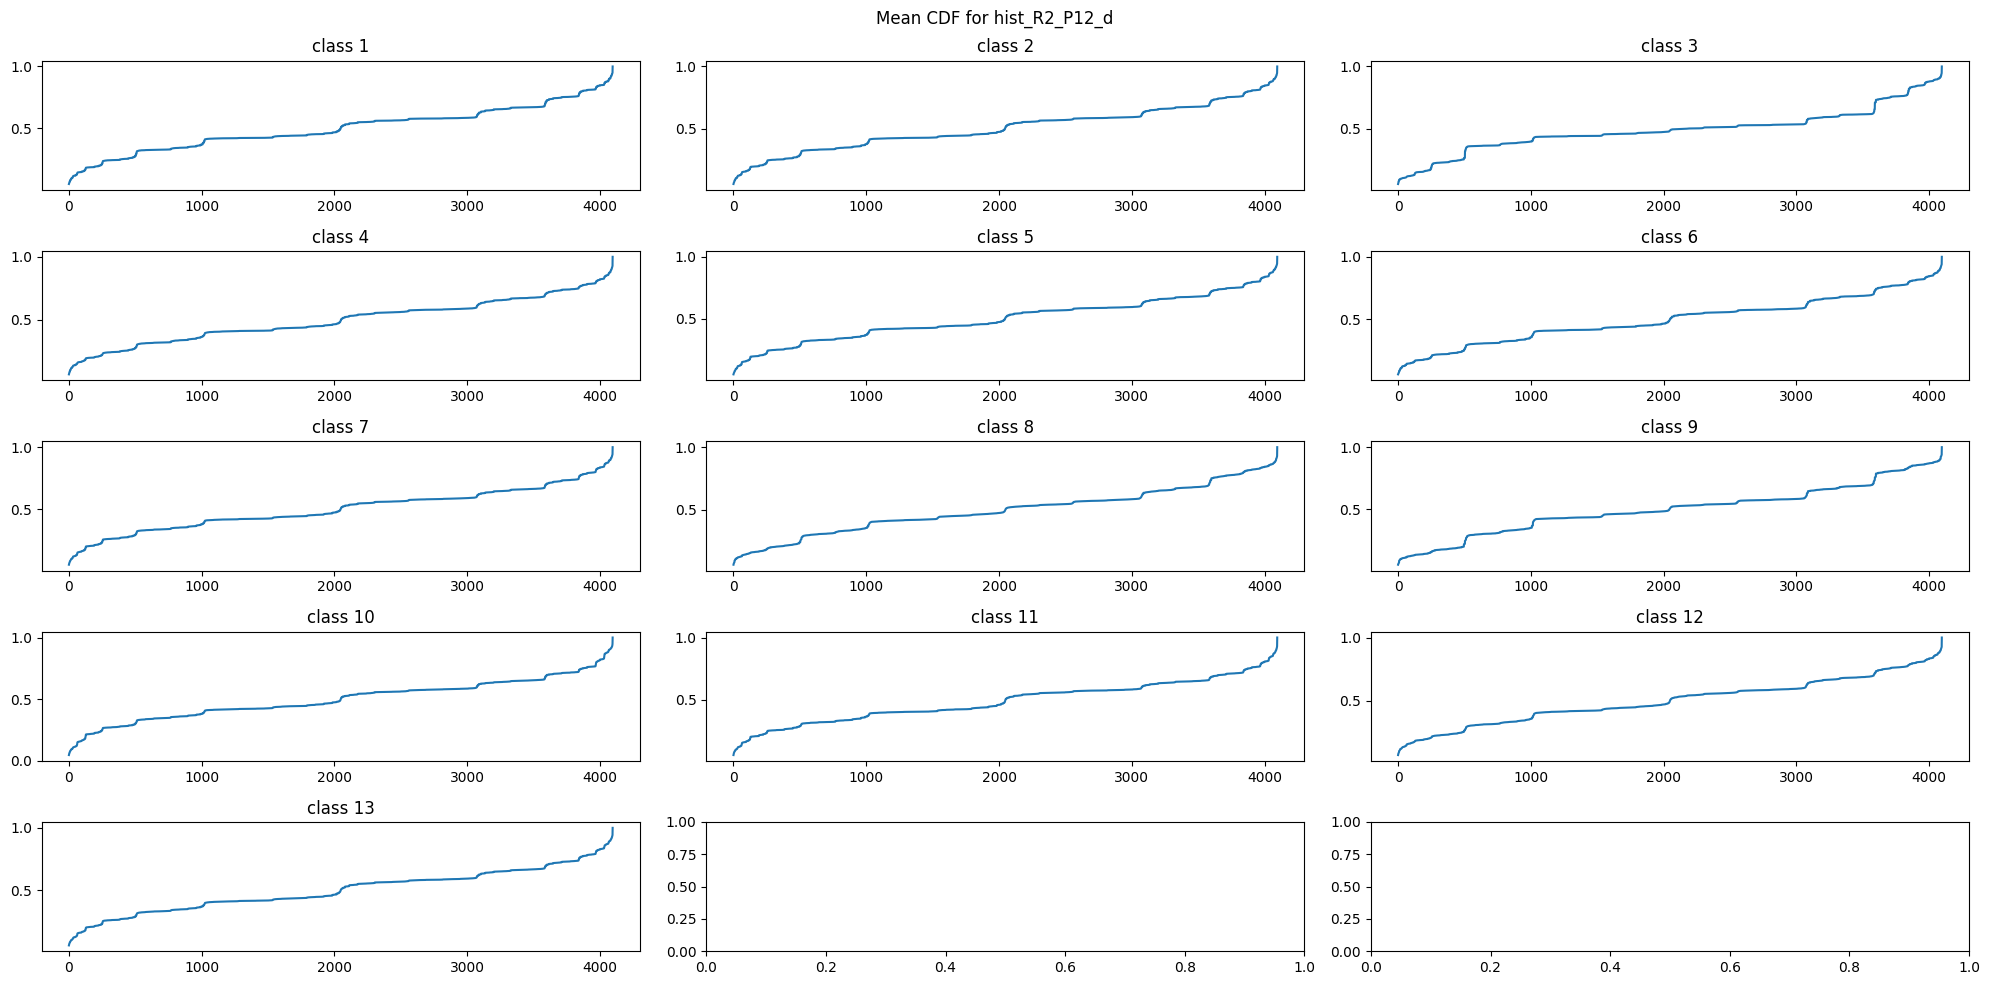

In [30]:
fig, axs = plt.subplots(5, 3)
for k in range(13):
    ax = axs.flat[k]
    ax.plot(range(means_cdf.shape[1]), means_cdf[k], '-')
    ax.set_title(f'class {k+1}')
# for k in range(13,len(axs)):
#     axs.flat[k].set_axis_off()
fig.suptitle(f'Mean CDF for {descriptor}')
fig.set_size_inches((20,10))
fig.tight_layout()

### Most abundand features

In [31]:
# means_int = means.astype(np.uint32)
sorted_means = np.ascontiguousarray(np.sort(means, axis=1)[:, ::-1]) / (chunksize**2)   # descending order
sorted_means.shape, sorted_means.dtype

((13, 4096), dtype('float64'))

In [32]:
sorted_means_cdf = sorted_means.cumsum(axis=1)
sorted_means_cdf.shape, sorted_means_cdf.dtype

((13, 4096), dtype('float64'))

In [33]:
sorted_means_cdf.max(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

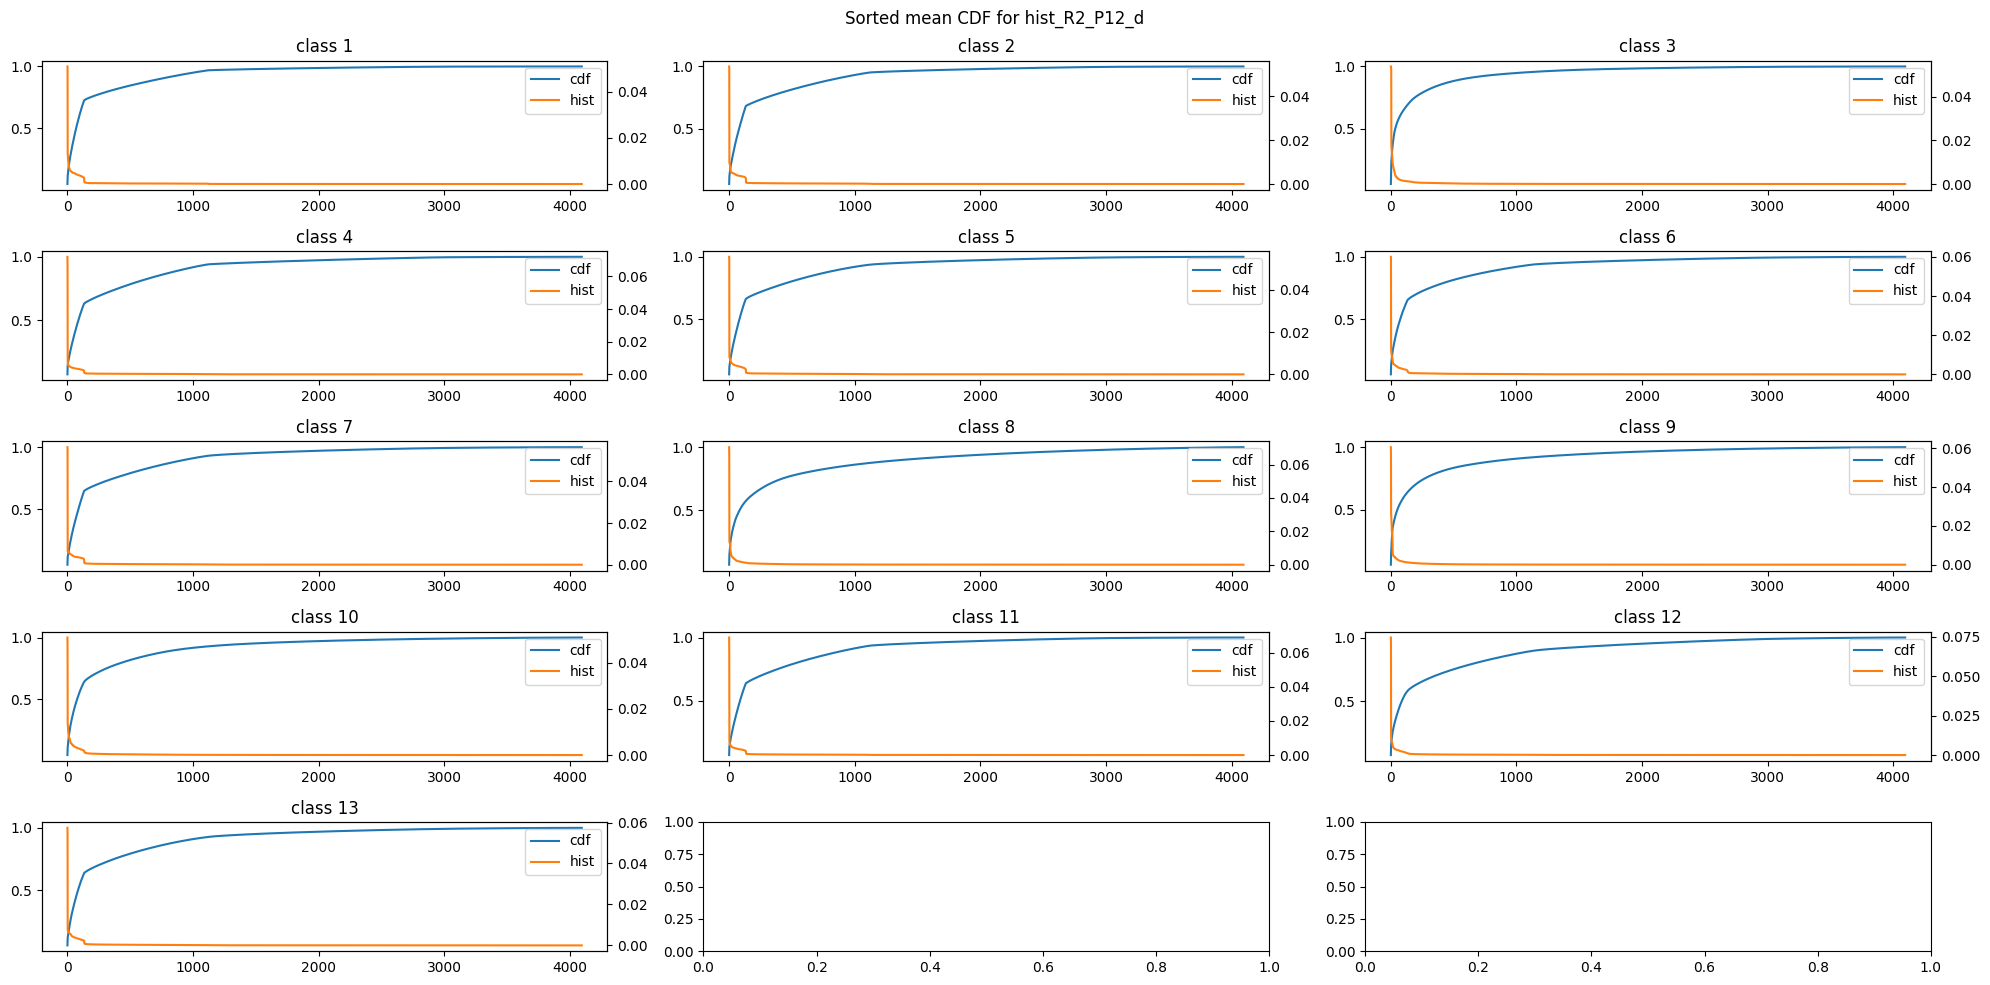

In [34]:
fig, axs = plt.subplots(5, 3)
for k in range(13):
    ax = axs.flat[k]
    a, = ax.plot(range(sorted_means_cdf.shape[1]), sorted_means_cdf[k], '-', color='C0', label='cdf')
    b, = ax.twinx().plot(range(sorted_means_cdf.shape[1]), sorted_means[k], '-', color='C1', label='hist')
    ax.set_title(f'class {k+1}')
    ax.legend(handles=[a,b])
for k in range(13,len(axs)):
    axs.flat[k].set_axis_off()
fig.suptitle(f'Sorted mean CDF for {descriptor}')
fig.set_size_inches((20,10))
fig.tight_layout()

В цілому достатньо 50 фіч, але це перевіримо пізніше

## 2. Normality

In [35]:
# Відхилення кожного спостереження від середнього
delta = np.array([ X_cl[k] - means[k] for k in range(13) ])
delta.shape, delta.dtype

((13, 150, 4096), dtype('float64'))

In [36]:
alpha = 0.05
print("Number of likely normal features using D’Agostino, R. and Pearson, E. S. test")
for k in range(13):
    s, pvals = sp.stats.normaltest(delta[k], axis=0)
    res = (pvals > alpha).sum()
    print(f"Class {k+1:2}: {res:3}/{delta.shape[-1]}")

Number of likely normal features using D’Agostino, R. and Pearson, E. S. test
Class  1: 125/4096
Class  2: 244/4096
Class  3:  40/4096
Class  4: 234/4096
Class  5: 212/4096
Class  6: 201/4096
Class  7: 251/4096
Class  8:  47/4096
Class  9: 132/4096
Class 10: 133/4096
Class 11: 325/4096
Class 12: 253/4096
Class 13: 190/4096


In [37]:
alpha = 0.05
print("Number of likely normal features using Shapiro-Wilk test")
for k in range(13):
    s, pvals = sp.stats.shapiro(delta[k], axis=0)
    res = (pvals > alpha).sum()
    print(f"Class {k+1:2}: {res:3}/{delta.shape[-1]}")

Number of likely normal features using Shapiro-Wilk test
Class  1: 343/4096


y:\kau\диплом\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:657: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  return result_to_tuple(hypotest_fun_out(*samples, **kwds), n_out)


Class  2: 125/4096
Class  3:  84/4096
Class  4: 110/4096
Class  5:  62/4096
Class  6:  45/4096
Class  7:  73/4096
Class  8:   9/4096
Class  9:  31/4096
Class 10:  34/4096
Class 11: 113/4096
Class 12:  55/4096
Class 13:  54/4096


## 3. Distribution similarity

### 3.1. Between classes

In [40]:
means_norm = (means + 1) / (chunksize**2)

In [41]:
# how class j is similar to class i
class_similarity = np.zeros((13,13), dtype=np.float64)
class_similarity_p = np.zeros((13,13), dtype=np.float64)

alpha = 0.05
for c1 in tqdm(range(13)): 
    for c2 in tqdm(range(13), desc="> "):
        if c1 == c2: continue
        stat, pval = sp.stats.power_divergence(f_obs=means[c2], f_exp=means[c1], lambda_='log-likelihood')
        class_similarity[c1,c2] = stat
        class_similarity_p[c1,c2] = pval

100%|██████████| 13/13 [00:00<00:00, 99.40it/s]


In [46]:
import seaborn as sb

<Axes: >

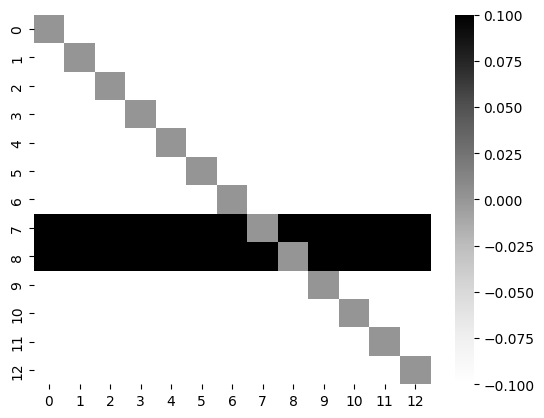

In [47]:
sb.heatmap(class_similarity, cmap='Greys')

Text(0.5, 1.0, 'hist_R2_P12_d\np-value for log-L dist similarity test between classes')

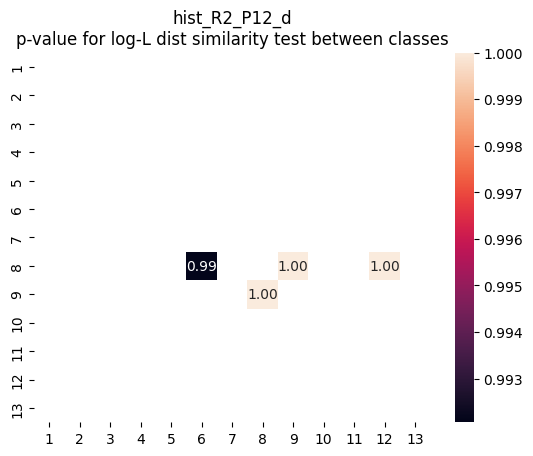

In [48]:
p_mask = class_similarity_p < alpha
sb.heatmap(class_similarity_p, annot=True, fmt=".2f", mask=p_mask, xticklabels=range(1,14), yticklabels=range(1,14))
plt.title(
    f"{descriptor}\n"
    "p-value for log-L dist similarity test between classes"
)

## 4. Performance

In [56]:
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, label, test_size=0.5, random_state=2225, stratify=label)
X_train.shape, y_train.shape

((975, 4096), (975,))

In [57]:
unique_labels, label_sizes = np.unique(y_train, return_counts=True)
X_train_cl = np.array([ X_train[y_train == k] for k in unique_labels])
means_train = X_train_cl.mean(axis=1) + 1   # +1 to avoid small values

In [58]:
def predict_naive(x):
    # x should be a non-normed histogram
    distances, pvalues = sp.stats.power_divergence( f_obs=(x+1), f_exp=means_train, axis=1, lambda_='log-likelihood')
    assert len(distances) == len(unique_labels)
    return unique_labels[np.argmin(distances)]

In [59]:
pred_classes = np.zeros_like(y_test)
for i in tqdm(range(y_test.shape[0])):
    pred_classes[i] = predict_naive(X_test[i])


100%|██████████| 975/975 [00:02<00:00, 339.51it/s]


In [60]:
confusion = skl.metrics.confusion_matrix(y_test, pred_classes, labels=unique_labels)

Text(0.5, 1.0, 'hist_R2_P12_d. Naive argmin-log-L-stat classifier')

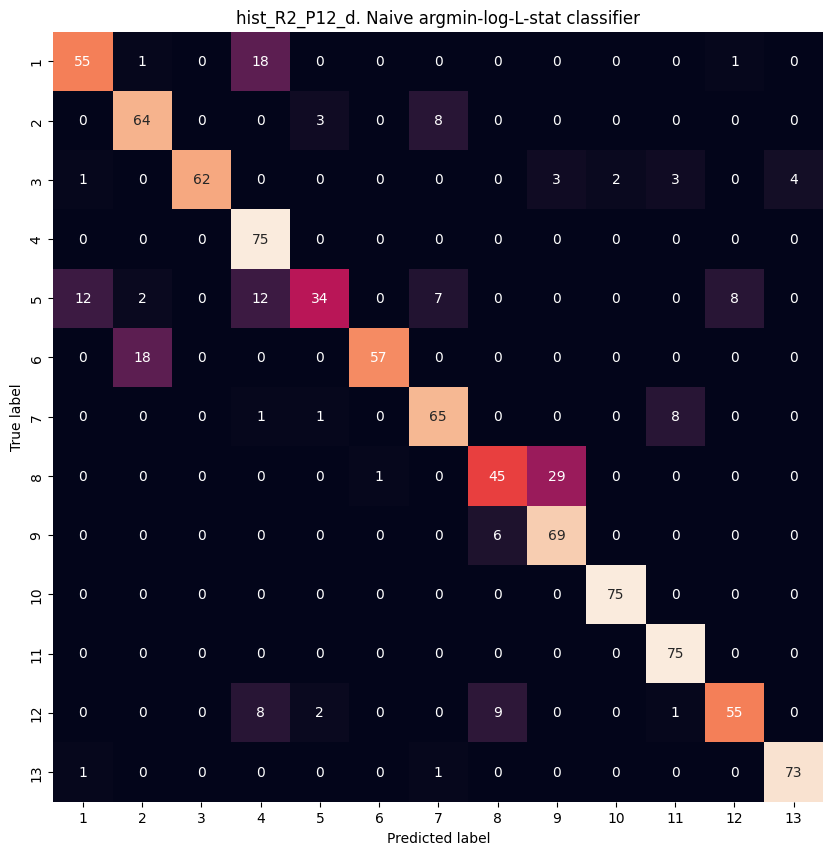

In [61]:
sb.heatmap(confusion, annot=True, fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, square=True, cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label');
plt.gcf().set_size_inches((10,10))
plt.title(f"{descriptor}. Naive argmin-log-L-stat classifier")

In [62]:
print(f"Balanced accuracy score: {skl.metrics.balanced_accuracy_score(y_test, pred_classes):.3f}")
print(f"F1-score[macro]: {skl.metrics.f1_score(y_test, pred_classes, labels=unique_labels, average='macro'):.3f}")
print(f"F1-score[micro]: {skl.metrics.f1_score(y_test, pred_classes, labels=unique_labels, average='micro'):.3f}")

Balanced accuracy score: 0.825
F1-score[macro]: 0.820
F1-score[micro]: 0.825
